In [1]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

First I write the link where the table is.

In [2]:
website_url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

Second I use BeautifulSoup package to scrap the data.

In [3]:
soup = BeautifulSoup(website_url,'lxml')

Then, I found the table I require.

In [4]:
My_table = soup.find('table',{'class':'wikitable sortable'})

I read the table 

In [5]:
df=pd.read_html(str(My_table))[0]

I deleted the rows with Not assigned Borough

In [6]:
data=df.loc[df['Borough']!='Not assigned']

I changed Neibourhoods not assigned

In [7]:
data.loc[data['Neighbourhood']=='Not assigned','Neighbourhood']=data.loc[data['Neighbourhood']=='Not assigned','Borough']

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [8]:
data.head()

,Postcode,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor


In [9]:
data.rename(columns={'Neighbourhood':'Neighborhood'},inplace=True)

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [10]:
data.shape

(210, 3)

I made my work in IBM Watson Studio so I had to delete my credentials.

In [11]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
df_data_0 = pd.read_csv(body)
df_data_0.head()


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


I merged both datasets

In [12]:
geodata=data.merge(df_data_0,'left',left_on='Postcode',right_on='Postal Code',indicator=True)

In [13]:
geodata.groupby('_merge').count()

,Postcode,Borough,Neighborhood,Postal Code,Latitude,Longitude
_merge,,,,,,
left_only,0,0,0,0,0,0
right_only,0,0,0,0,0,0
both,210,210,210,210,210,210


In [14]:
geodata.drop(inplace=True,columns='_merge')

In [15]:
geodata.head()

,Postcode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,M5A,43.654260,-79.360636
3,M6A,North York,Lawrence Heights,M6A,43.718518,-79.464763
4,M6A,North York,Lawrence Manor,M6A,43.718518,-79.464763


Lets take only the Borough win Toronto in it.

In [16]:
geodata=geodata.loc[np.array(['Toronto' in borough for borough in geodata['Borough']])]

In [17]:
geodata.head()

,Postcode,Borough,Neighborhood,Postal Code,Latitude,Longitude
2,M5A,Downtown Toronto,Harbourfront,M5A,43.654260,-79.360636
12,M5B,Downtown Toronto,Ryerson,M5B,43.657162,-79.378937
13,M5B,Downtown Toronto,Garden District,M5B,43.657162,-79.378937
26,M5C,Downtown Toronto,St. James Town,M5C,43.651494,-79.375418
35,M4E,East Toronto,The Beaches,M4E,43.676357,-79.293031


In [18]:
from geopy.geocoders import Nominatim
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


Lets see the Neighbourhoods

In [19]:
!pip install folium

     |████████████████████████████████| 92kB 15.5MB/s eta 0:00:01


In [20]:
import folium 

# create map of Manhattan using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(geodata['Latitude'], geodata['Longitude'], geodata['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Now I'm going to use Foursquare API

In [21]:
CLIENT_ID = 'WMZMBR2ZPFG0T35EU4NEQCHE0TDEO3YHVZTD1GZ0FYXEW3XT' # your Foursquare ID
CLIENT_SECRET = 'VMBTK3J1HIYOFHNRLDZS3SOLCX3GXEIACXWUHKTBE5534035' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WMZMBR2ZPFG0T35EU4NEQCHE0TDEO3YHVZTD1GZ0FYXEW3XT
CLIENT_SECRET:VMBTK3J1HIYOFHNRLDZS3SOLCX3GXEIACXWUHKTBE5534035


The next funtion was created in the Lab, to explore Neighbourhoods

In [22]:
LIMIT=100

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
toronto_venues = getNearbyVenues(names=geodata['Neighborhood'],
                                   latitudes=geodata['Latitude'],
                                   longitudes=geodata['Longitude']
                                  )

How many unique categories

In [25]:
print(toronto_venues.shape)
toronto_venues.head()


(3205, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Harbourfront,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,Harbourfront,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,Harbourfront,43.65426,-79.360636,Cooper Koo Family YMCA,43.653191,-79.357947,Gym / Fitness Center
3,Harbourfront,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,Harbourfront,43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot


In [26]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 233 uniques categories.


## Analize each Neighbourhood

In [27]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grouped rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [28]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint
0,Adelaide,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,...,0.000000,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000
1,Bathurst Quay,0.000000,0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.071429,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000
3,Brockton,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Business Reply Mail Processing Centre 969 Eastern,0.055556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,CN Tower,0.000000,0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.071429,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Cabbagetown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Central Bay Street,0.011905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,...,0.000000,0.000000,0.000000,0.00,0.011905,0.000000,0.000000,0.011905,0.000000,0.000000
8,Chinatown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010526,0.000000,0.000000,0.00,0.031579,0.000000,0.052632,0.010526,0.000000,0.000000
9,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


I printed each neighborhood along with the top 5 most common venues

In [29]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide----
             venue  freq
0      Coffee Shop  0.07
1             Café  0.05
2              Bar  0.04
3       Steakhouse  0.04
4  Thai Restaurant  0.04


----Bathurst Quay----
             venue  freq
0   Airport Lounge  0.14
1  Airport Service  0.14
2            Plane  0.07
3  Harbor / Marina  0.07
4    Boat or Ferry  0.07


----Berczy Park----
          venue  freq
0   Coffee Shop  0.08
1        Bakery  0.05
2  Cocktail Bar  0.03
3      Beer Bar  0.03
4          Café  0.03


----Brockton----
            venue  freq
0            Café  0.09
1  Breakfast Spot  0.09
2     Coffee Shop  0.09
3     Music Venue  0.05
4         Stadium  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0    Light Rail Station  0.11
1           Yoga Studio  0.06
2                   Spa  0.06
3  Gym / Fitness Center  0.06
4         Garden Center  0.06


----CN Tower----
             venue  freq
0   Airport Lounge  0.14
1  Airport Service  0.14
2       

Sorting venues in descending order and display the top 10 venues for each neighborhood.

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adelaide,Coffee Shop,Café,Bar,Thai Restaurant,Steakhouse,Bakery,Asian Restaurant,Sushi Restaurant,Burger Joint,American Restaurant
1,Bathurst Quay,Airport Lounge,Airport Service,Harbor / Marina,Airport Terminal,Plane,Sculpture Garden,Boat or Ferry,Bar,Coffee Shop,Airport
2,Berczy Park,Coffee Shop,Bakery,Farmers Market,Cocktail Bar,Café,Cheese Shop,Steakhouse,Seafood Restaurant,Beer Bar,Jazz Club
3,Brockton,Breakfast Spot,Coffee Shop,Café,Stadium,Bar,Intersection,Bakery,Restaurant,Climbing Gym,Burrito Place
4,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Auto Workshop,Park,Comic Shop,Pizza Place,Restaurant,Burrito Place,Brewery,Skate Park,Smoke Shop


## Clustering Neighborhoods

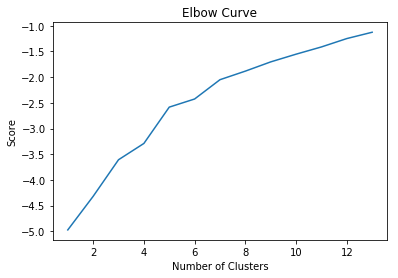

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

X=toronto_grouped.drop('Neighborhood', 1)
Nc = range(1, 14)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

It's not really clear how many clusters are appropiate to do an analysis, I took 6.

In [44]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 6

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 0], dtype=int32)

Adding cluster labels

In [46]:
# add clustering labels
neighborhoods_venues_sorted.drop(columns=['Cluster Labels'],inplace=True)
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = geodata

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postcode,Borough,Neighborhood,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,Harbourfront,M5A,43.654260,-79.360636,0,Coffee Shop,Bakery,Pub,Park,Mexican Restaurant,Breakfast Spot,Restaurant,Café,Theater,Yoga Studio
12,M5B,Downtown Toronto,Ryerson,M5B,43.657162,-79.378937,0,Coffee Shop,Clothing Store,Bakery,Café,Fast Food Restaurant,Cosmetics Shop,Restaurant,Bubble Tea Shop,Burger Joint,Pizza Place
13,M5B,Downtown Toronto,Garden District,M5B,43.657162,-79.378937,0,Coffee Shop,Clothing Store,Bakery,Café,Fast Food Restaurant,Cosmetics Shop,Restaurant,Bubble Tea Shop,Burger Joint,Pizza Place
26,M5C,Downtown Toronto,St. James Town,M5C,43.651494,-79.375418,0,Coffee Shop,Café,Restaurant,Hotel,Bakery,Italian Restaurant,Clothing Store,Gastropub,Pizza Place,Breakfast Spot
35,M4E,East Toronto,The Beaches,M4E,43.676357,-79.293031,4,Health Food Store,Trail,Pub,Wings Joint,Department Store,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop


## Visualizing cluster

In [47]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### cluster 1

In [48]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Downtown Toronto,-79.360636,0,Coffee Shop,Bakery,Pub,Park,Mexican Restaurant,Breakfast Spot,Restaurant,Café,Theater,Yoga Studio
12,Downtown Toronto,-79.378937,0,Coffee Shop,Clothing Store,Bakery,Café,Fast Food Restaurant,Cosmetics Shop,Restaurant,Bubble Tea Shop,Burger Joint,Pizza Place
13,Downtown Toronto,-79.378937,0,Coffee Shop,Clothing Store,Bakery,Café,Fast Food Restaurant,Cosmetics Shop,Restaurant,Bubble Tea Shop,Burger Joint,Pizza Place
26,Downtown Toronto,-79.375418,0,Coffee Shop,Café,Restaurant,Hotel,Bakery,Italian Restaurant,Clothing Store,Gastropub,Pizza Place,Breakfast Spot
36,Downtown Toronto,-79.373306,0,Coffee Shop,Bakery,Farmers Market,Cocktail Bar,Café,Cheese Shop,Steakhouse,Seafood Restaurant,Beer Bar,Jazz Club
40,Downtown Toronto,-79.387383,0,Coffee Shop,Ice Cream Shop,Café,Italian Restaurant,Sandwich Place,Burger Joint,Salad Place,Chinese Restaurant,Bakery,Gym / Fitness Center
41,Downtown Toronto,-79.422564,0,Grocery Store,Café,Park,Coffee Shop,Convenience Store,Baby Store,Nightclub,Diner,Italian Restaurant,Restaurant
48,Downtown Toronto,-79.384568,0,Coffee Shop,Café,Bar,Thai Restaurant,Steakhouse,Bakery,Asian Restaurant,Sushi Restaurant,Burger Joint,American Restaurant
49,Downtown Toronto,-79.384568,0,Coffee Shop,Café,Bar,Thai Restaurant,Steakhouse,Bakery,Asian Restaurant,Sushi Restaurant,Burger Joint,American Restaurant
50,Downtown Toronto,-79.384568,0,Coffee Shop,Café,Bar,Thai Restaurant,Steakhouse,Bakery,Asian Restaurant,Sushi Restaurant,Burger Joint,American Restaurant


It seems cluster one is popular for having places to take a breakfast.